In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [4]:
df = pd.read_csv("stash_frequency_updates/heist.csv")

In [61]:
df.sample(3)

,created_at,change_id,account_name,last_character_name,stash_id
2581524,2021-01-02 19:39:00.987972,920531473-931580663-893405168-1005853299-78855892,MbyM,nopunch_heist,0250e3945dfc29e2a3e2d279c2a42d66cbb3c213cea0c8...
10256481,2020-12-13 15:18:30.334684,908306404-919609614-881805689-992809912-951233457,dejv,hajstdejv,40cf7790e49f0121d3a4310132625066c62fdb5636a116...
883003,2020-12-28 05:59:21.845983,917429196-928606633-890500971-1002389210-27658223,Eggar,NeedThatCat,bfe95252ebb192988a82ea6c4cbe68c6dfc8cf6275aee2...


In [62]:
df.describe()

,created_at,change_id,account_name,last_character_name,stash_id
count,14755243,14755243,14755243,14755155,14755243
unique,2516147,2516145,108455,213591,1444282
top,2020-12-18 17:37:54.127872,910238466-921510967-883700011-994744076-953145936,따아용,안이쁘다,bb726172506ff285edc0760078577b9b21618cd41c3de7...
freq,367,367,22367,21831,2706


# Stash Type Usage

In [ ]:
print("Unique stash types: {}".format(df["stash_type"].unique()))

In [64]:
df.columns

Index(['created_at', 'change_id', 'account_name', 'last_character_name',
       'stash_id'],
      dtype='object')

In [ ]:
df.groupby("stash_type").count().plot.bar(y="created_at", label="Stash Type", figsize=(10, 5))

# Account Names

In [66]:
unique_account_names = df.groupby("account_name").count()
unique_account_names["created_at"].describe()

count    108455.000000
mean        136.049449
std         476.014479
min           1.000000
25%           3.000000
50%          14.000000
75%          73.000000
max       22367.000000
Name: created_at, dtype: float64

There were 1914 unique accounts

Text(0.5, 1.0, 'account_name distribution')

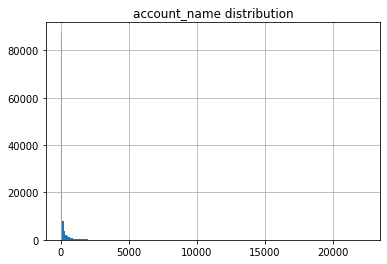

In [68]:
unique_account_names["created_at"].hist(bins=200)
plt.title("account_name distribution")
#plt.yscale("log")

# Stash Update Frequency per Account Name

- Calculate differences between stash_records created_at fields for each account
- cycle over window and reduce stash_records to list (n - 1) of second differences
- look at some distributions
    - look into how to compare distributions in here
    - plotting all of them is probably not feasible
    - probably plot histogram of median/average values

In [30]:
ticks = df.groupby("account_name")['created_at'].apply(list).to_dict()

In [31]:
import datetime
import dateutil.parser

def with_indexing(dstr):                              
    return datetime.datetime(*map(int, [dstr[:4], dstr[5:7], dstr[8:10], dstr[11:13], dstr[14:16], dstr[17:19]])) 

def reduce_to_diffs(timestamps):
    tick_diffs = list()
    for idx, ts in enumerate(timestamps):
        if idx == 0:
            continue
        d1 = with_indexing(ts)
        d2 = with_indexing(timestamps[idx - 1])
        diff = round((d1 - d2).total_seconds())

        # We can safely filter out 0 values, since that only means we got two update ticks for two different stashes within the same change_id with the same created_at timestamp.
        # For our current goal, all ticks at the same timestamp can be viewed as one, because we only care for each player's update frequency.
        if diff > 0 and diff < 3600:
            tick_diffs.append(diff)
    return tick_diffs

In [32]:
for key in ticks.keys():
    ticks[key] = reduce_to_diffs(ticks[key])

In [33]:
stats = dict()
for key in ticks.keys():
    tick_diffs = ticks[key]
    if len(tick_diffs) <= 100:
        continue
    
    tick_diffs_df = pd.DataFrame({ "tick_diffs": tick_diffs})
    stats[key] = tick_diffs_df.describe().to_dict()["tick_diffs"]
    stats[key]["99%"] = np.percentile(tick_diffs, 99)
    stats[key]["98%"] = np.percentile(tick_diffs, 98)
    stats[key]["95%"] = np.percentile(tick_diffs, 95)    
    stats[key]["90%"] = np.percentile(tick_diffs, 90)

    #print(stats[key])

In [34]:
stats_df = pd.DataFrame(stats).transpose()

In [35]:
stats_df

,count,mean,std,min,25%,50%,75%,max,99%,98%,95%,90%
--GoldFish--,175.0,1084.834286,749.799920,52.0,515.00,839.0,1535.00,3547.0,3431.70,2895.00,2517.10,2113.2
0000000000000000000000000,223.0,652.165919,473.775999,1.0,359.00,536.0,899.00,2700.0,2152.18,1828.44,1510.40,1321.8
01Jeff,409.0,893.706601,815.305790,1.0,360.00,642.0,1100.00,3546.0,3408.04,3276.56,2851.00,2112.0
034mks034,301.0,851.564784,695.387340,1.0,365.00,641.0,1112.00,3587.0,3200.00,3020.00,2402.00,1694.0
0486,1268.0,557.671136,532.385872,2.0,208.75,441.0,685.75,3581.0,2830.59,2355.60,1668.90,1086.9
...,...,...,...,...,...,...,...,...,...,...,...,...
히어로즈오브스톰,165.0,510.369697,463.309348,9.0,215.00,383.0,654.00,2921.0,2044.84,1933.32,1422.60,983.2
힐스테이트,2445.0,467.017587,469.199651,1.0,176.00,336.0,588.00,3441.0,2448.20,2057.36,1357.20,983.4
힐해줄까요,129.0,1199.232558,823.818942,325.0,515.00,877.0,1636.00,3584.0,3377.28,3320.24,2956.40,2502.8
힘찬찬,308.0,849.110390,593.481645,8.0,439.75,708.0,1089.25,3326.0,2720.88,2634.08,2048.25,1652.5


In [36]:
stats_df.to_csv("tick_diff_stats_heist_sc.csv")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1853e03d0>]],
      dtype=object)

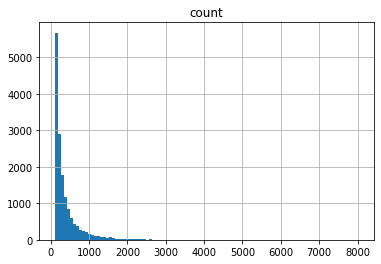

In [37]:
stats_df.hist("count", bins=100)
#plt.yscale("log")

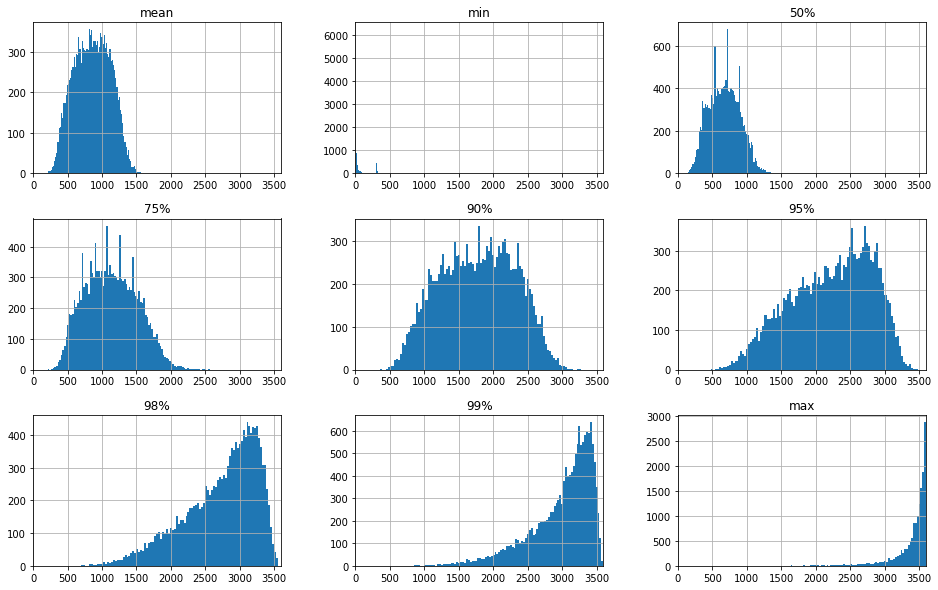

In [38]:
fig, axes = plt.subplots(3, 3, figsize=(16, 10))
columns = ["mean", "min", "50%", "75%", "90%", "95%", "98%", "99%", "max"]
for idx, col in enumerate(columns):
    r = int(idx / 3)
    c = idx % 3
    ax = axes[r, c]
    ax.set_xlim(0, 3600)
    stats_df.hist(column=col, bins=100, ax=ax)

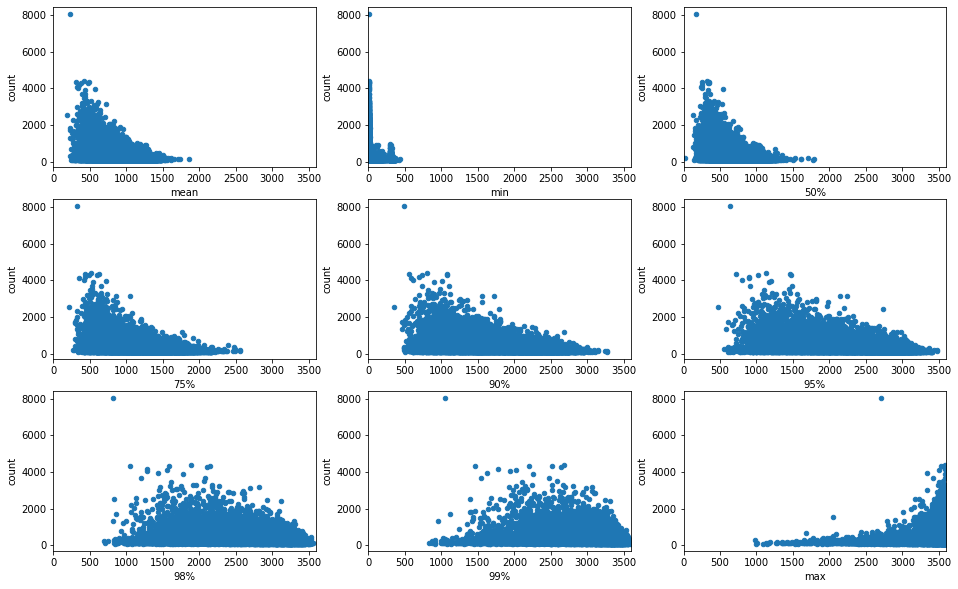

In [39]:
fig, axes = plt.subplots(3, 3, figsize=(16, 10))
columns = ["mean", "min", "50%", "75%", "90%", "95%", "98%", "99%", "max"]
for idx, col in enumerate(columns):
    r = int(idx / 3)
    c = idx % 3
    ax = axes[r, c]
    ax.set_xlim(0, 3600)
    stats_df.plot.scatter(x=col, y="count", ax=ax)

As of right now I'm not sure what to conclude from this.

Looking at the scatter plots, there is no clear indication of a group of accounts that is mostly (lets say 75% of stash updates) faster than the vast remaining majority of players.
My hope for this group of accounts to exist is of course based on the assumption that seller-accounts generate proportionately more stash updates than regular players or at least with a certain consistency (which imo should then show up in the plots above) compaired to regular players.

Apparently, looking at stash update frequency alone is not enough to indicate anything.
The next step would be to look at the most frequently updating accounts and look at the type of updates. 

Maybe we can deduce some account category from the type of stash updates, eg. many additions might be someone mapping and dumping everything in a quad stash tab.
Or someone that exchanges many kinds of item types (gear, currency, maps, etc.) for currency might be more of a trade type account.